# Guillaume Chacun

# Assignment 1 ATML 2020

In [1]:
import numpy as np
train_images = np.load('imgs_train.npy')
train_labels = np.load('labels_train.npy')

test_images = np.load('imgs_test.npy')
test_labels = np.load('labels_test.npy')

type(train_images), len(train_images), len(test_images)

(numpy.ndarray, 5000, 8000)

## Task 1. Prepare data for training and model selection

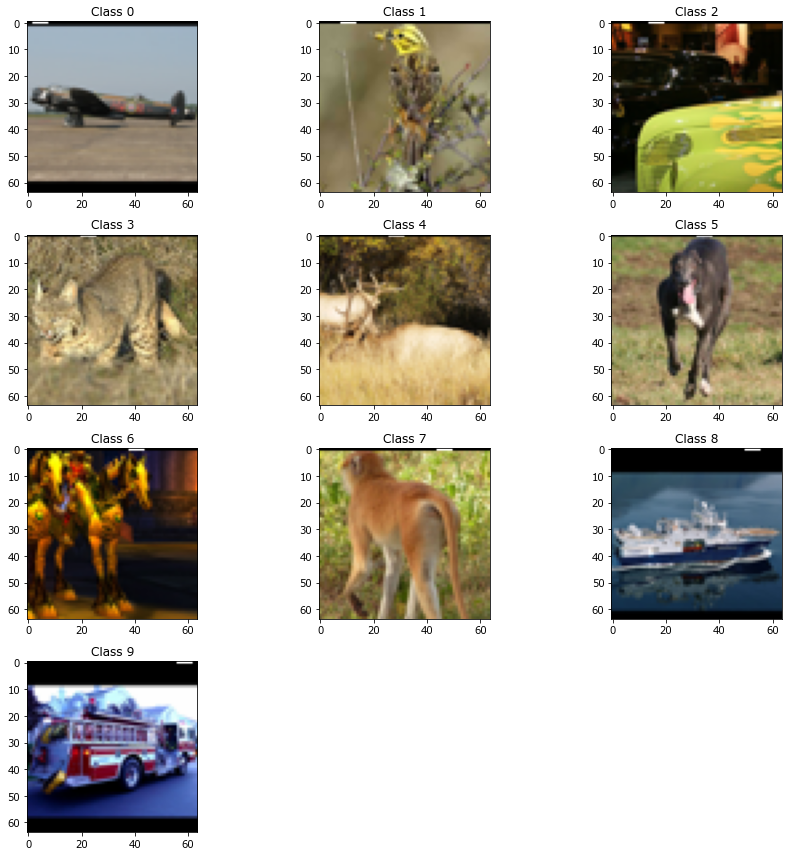

In [2]:
# plot one image per class
import matplotlib.pyplot as plt
import math
def plot_examples_from_dataset(images, labels):
    unique_labels = set(label for label in labels)
    ncols = 3
    nrows = math.ceil(len(unique_labels)/ncols)
    
    # plot one image of each class
    fig, axs = plt.subplots(nrows, ncols, figsize=(12,12))
    for label_to_plot in unique_labels:
        for image, label in zip(images, labels):
            if label == label_to_plot:
                plot = axs[label//ncols][label%ncols]
                plot.imshow(image)
                plot.title.set_text(f'Class {label}')
                break
    plt.tight_layout()
    
    # remove unused subplots
    overflow = (ncols * nrows) - len(unique_labels)
    for i in range(ncols-1, ncols-overflow-1, -1):
        fig.delaxes(axs[nrows-1][i])
    plt.show()

plot_examples_from_dataset(train_images, train_labels)

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from torch.utils.data import Dataset
class CustomTensorDataset(Dataset):
    """
    Custom tensor dataset for images and their labels as numpy ndarrays.
    Scales images before normalizing them. 
    Removes the first pixels' row of each image if the flag remove_first_row is set to True.
    """
    def __init__(self, images, labels, normalization, remove_first_row=True):
        assert len(images) == len(labels)
        
        if remove_first_row:
            images = np.delete(images, 0, axis=1) # remove images' first row of pixels
        images = np.divide(images, 255) # scale values in range [0;1]
        
        self.images = torch.Tensor(images)
        self.labels = torch.Tensor(labels)
        self.normalization = normalization

    def __getitem__(self, index):
        image = self.normalization(self.images[index]) # normalize data
        label = self.labels[index]
        return image, label

    def __len__(self):
        return len(self.images)

In [5]:
# prepare 10% of train for validation
from sklearn.model_selection import train_test_split 
# train_test_split will keep the same label distribution in train/val sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, 
                                                                      train_labels, 
                                                                      test_size=0.10, 
                                                                      stratify=train_labels)

In [6]:
# create datasets
from torchvision.transforms import Normalize
normalization = Normalize(mean=(0.5,), std=(0.5,))
remove_first_row = False

train_dataset = CustomTensorDataset(train_images, train_labels, normalization, remove_first_row)
validation_dataset = CustomTensorDataset(val_images, val_labels, normalization, remove_first_row)
test_dataset = CustomTensorDataset(test_images, test_labels, normalization, remove_first_row)

In [7]:
# create dataloaders
from torch.utils.data import DataLoader
num_workers = 0
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

## Task 2. Train a linear classification model

In [8]:
import torch.nn as nn
class LinearModel(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=True)
        
    def forward(self, input):
        out = input.view(input.size(0), -1)
        out = self.linear(out) 
        return out

In [9]:
# initialize parameters, model, optimizer and loss function
import numpy as np

# set parameters
n_epochs = 100
learning_rate = 0.1 # 0.1, 0.05, 0.01, 0.005, 0.001
input_shape = train_dataloader.dataset.images[0].shape
input_dim = np.prod(input_shape)
output_dim = 10

# initialize model
model = LinearModel(input_dim, output_dim)
model = model.to(device)

# initialize optimizer and loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [10]:
import statistics
def train_epoch(model, train_dataloader, optimizer, loss_fn):
    losses = []
    correct_predictions = 0
    model.train() # switch model to training mode
    
    for iteration, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device, dtype=torch.int64)
        
        # set gradients to zero
        optimizer.zero_grad()
        
        # forward, backward & optimize
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # save metrics
        losses.append(loss.item())
        correct_predictions += (outputs.argmax(dim=1) == labels).sum().item()
        
        if iteration % 16 == 0:
            print('Training iteration {}: loss {:.4f}'.format(iteration, loss.item()))
            
    # compute & print statistics
    average_loss = statistics.mean(losses)
    accuracy = 100.0 * correct_predictions / len(train_dataloader.dataset)
    print(f'Train average loss: {round(average_loss,4)}, accuracy: {round(accuracy,3)}')
    return average_loss, accuracy

In [11]:
def evaluate(model, val_dataloader, loss_fn, validation=True):
    losses = []
    correct_predictions = 0
    model.eval()
    
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.int64)
            
            # predict & compute loss
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # save metrics
            losses.append(loss.item())
            correct_predictions += (outputs.argmax(dim=1) == labels).sum().item()

    # compute & print statistics
    average_loss = statistics.mean(losses)
    accuracy = 100.0 * correct_predictions / len(val_dataloader.dataset)
    print(f'{"Validation" if validation else "Test"} average loss: {round(average_loss,4)}, accuracy: {round(accuracy,3)}')
    return average_loss, accuracy

In [12]:
# train the model
def train(model, train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in range(n_epochs):
        print('Epoch {}'.format(epoch+1))

        # train
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_fn)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # validation
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    return train_losses, train_accuracies, val_losses, val_accuracies
    
train_losses, train_accuracies, val_losses, val_accuracies = train(model, 
                                                                   train_dataloader, val_dataloader, 
                                                                   optimizer, loss_fn, 
                                                                   n_epochs)

Epoch 1
Training iteration 0: loss 2.3356
Training iteration 16: loss 2.5832
Training iteration 32: loss 0.0123
Training iteration 48: loss 0.0076
Training iteration 64: loss 0.0015
Train average loss: 1.9776, accuracy: 82.867
Validation average loss: 0.0038, accuracy: 100.0
Epoch 2
Training iteration 0: loss 0.0034
Training iteration 16: loss 0.0021
Training iteration 32: loss 0.0012
Training iteration 48: loss 0.0021
Training iteration 64: loss 0.0010
Train average loss: 0.0017, accuracy: 100.0
Validation average loss: 0.0019, accuracy: 100.0
Epoch 3
Training iteration 0: loss 0.0017
Training iteration 16: loss 0.0007
Training iteration 32: loss 0.0009
Training iteration 48: loss 0.0006
Training iteration 64: loss 0.0009
Train average loss: 0.001, accuracy: 100.0
Validation average loss: 0.0015, accuracy: 100.0
Epoch 4
Training iteration 0: loss 0.0007
Training iteration 16: loss 0.0004
Training iteration 32: loss 0.0006
Training iteration 48: loss 0.0010
Training iteration 64: loss 

Validation average loss: 0.0004, accuracy: 100.0
Epoch 31
Training iteration 0: loss 0.0003
Training iteration 16: loss 0.0002
Training iteration 32: loss 0.0002
Training iteration 48: loss 0.0002
Training iteration 64: loss 0.0002
Train average loss: 0.0002, accuracy: 100.0
Validation average loss: 0.0004, accuracy: 100.0
Epoch 32
Training iteration 0: loss 0.0003
Training iteration 16: loss 0.0002
Training iteration 32: loss 0.0002
Training iteration 48: loss 0.0003
Training iteration 64: loss 0.0002
Train average loss: 0.0002, accuracy: 100.0
Validation average loss: 0.0004, accuracy: 100.0
Epoch 33
Training iteration 0: loss 0.0002
Training iteration 16: loss 0.0002
Training iteration 32: loss 0.0003
Training iteration 48: loss 0.0002
Training iteration 64: loss 0.0002
Train average loss: 0.0002, accuracy: 100.0
Validation average loss: 0.0004, accuracy: 100.0
Epoch 34
Training iteration 0: loss 0.0003
Training iteration 16: loss 0.0002
Training iteration 32: loss 0.0002
Training i

Training iteration 64: loss 0.0001
Train average loss: 0.0001, accuracy: 100.0
Validation average loss: 0.0002, accuracy: 100.0
Epoch 61
Training iteration 0: loss 0.0002
Training iteration 16: loss 0.0002
Training iteration 32: loss 0.0001
Training iteration 48: loss 0.0001
Training iteration 64: loss 0.0001
Train average loss: 0.0001, accuracy: 100.0
Validation average loss: 0.0002, accuracy: 100.0
Epoch 62
Training iteration 0: loss 0.0001
Training iteration 16: loss 0.0002
Training iteration 32: loss 0.0001
Training iteration 48: loss 0.0001
Training iteration 64: loss 0.0001
Train average loss: 0.0001, accuracy: 100.0
Validation average loss: 0.0002, accuracy: 100.0
Epoch 63
Training iteration 0: loss 0.0001
Training iteration 16: loss 0.0001
Training iteration 32: loss 0.0001
Training iteration 48: loss 0.0002
Training iteration 64: loss 0.0001
Train average loss: 0.0001, accuracy: 100.0
Validation average loss: 0.0002, accuracy: 100.0
Epoch 64
Training iteration 0: loss 0.0001
T

Training iteration 32: loss 0.0001
Training iteration 48: loss 0.0001
Training iteration 64: loss 0.0001
Train average loss: 0.0001, accuracy: 100.0
Validation average loss: 0.0002, accuracy: 100.0
Epoch 91
Training iteration 0: loss 0.0001
Training iteration 16: loss 0.0001
Training iteration 32: loss 0.0001
Training iteration 48: loss 0.0001
Training iteration 64: loss 0.0001
Train average loss: 0.0001, accuracy: 100.0
Validation average loss: 0.0002, accuracy: 100.0
Epoch 92
Training iteration 0: loss 0.0001
Training iteration 16: loss 0.0001
Training iteration 32: loss 0.0001
Training iteration 48: loss 0.0001
Training iteration 64: loss 0.0001
Train average loss: 0.0001, accuracy: 100.0
Validation average loss: 0.0002, accuracy: 100.0
Epoch 93
Training iteration 0: loss 0.0001
Training iteration 16: loss 0.0001
Training iteration 32: loss 0.0001
Training iteration 48: loss 0.0001
Training iteration 64: loss 0.0001
Train average loss: 0.0001, accuracy: 100.0
Validation average loss

In [13]:
print(f'Average loss & accuracy after last training epoch (n° {n_epochs}):')
print(f'Train average loss: {round(train_losses[-1],4)}, accuracy: {round(train_accuracies[-1],4)}')
print(f'Validation average loss: {round(val_losses[-1],4)}, accuracy: {round(val_accuracies[-1],4)}')

Average loss & accuracy after last training epoch (n° 100):
Train average loss: 0.0001, accuracy: 100.0
Validation average loss: 0.0002, accuracy: 100.0


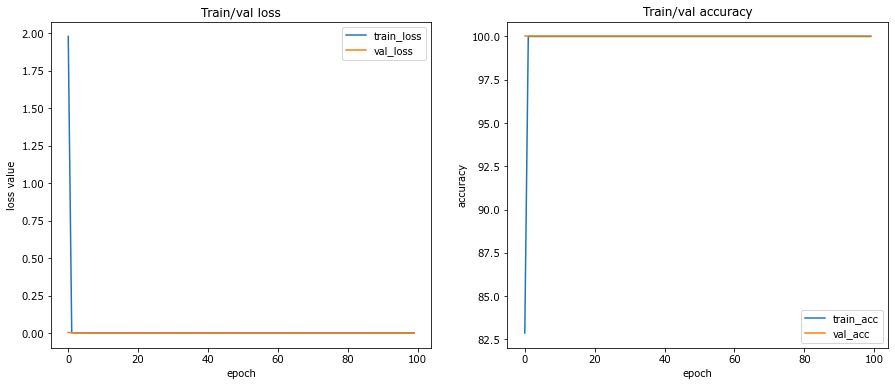

In [14]:
# plot training curves
def plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    fig, axs = plt.subplots(ncols=2, figsize=(15,6))
    # losses
    axs[0].plot(np.arange(n_epochs), train_losses)
    axs[0].plot(np.arange(n_epochs), val_losses)
    axs[0].legend(['train_loss', 'val_loss'])
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss value')
    axs[0].title.set_text('Train/val loss');

    # accuracies
    axs[1].plot(np.arange(n_epochs), train_accuracies)
    axs[1].plot(np.arange(n_epochs), val_accuracies)
    axs[1].legend(['train_acc', 'val_acc'])
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].title.set_text('Train/val accuracy');

plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

#### Report below:

##### Models comparison
<table align='left'>
    <tr>
        <th>Learning rate</th>
        <th>Average loss & accuracy</th>
        <th>After epoch 100</th>
    </tr>
    <tr>
        <td><b>0.001</b></td>
        <td><img src='task2_plots/lr_0-001.png' width='600'/></td>
        <td>Train average loss: 0.0192, accuracy: 100.0<br/>Validation average loss: 0.024, accuracy: 100.0</td>
    </tr>
    <tr>
        <td><b>0.005</b></td>
        <td><img src='task2_plots/lr_0-005.png' width='600'/></td>
        <td>Train average loss: 0.0035, accuracy: 100.0<br/>Validation average loss: 0.0049, accuracy: 100.0</td>
    </tr>
    <tr>
        <td><b>0.01</b></td>
        <td><img src='task2_plots/lr_0-01.png' width='600'/></td>
        <td>Train average loss: 0.0017, accuracy: 100.0<br/>Validation average loss: 0.0025, accuracy: 100.0</td>
    </tr>
    <tr>
        <td><b>0.05</b></td>
        <td><img src='task2_plots/lr_0-05.png' width='600'/></td>
        <td>Train average loss: 0.0003, accuracy: 100.0<br/>Validation average loss: 0.0005, accuracy: 100.0</td>
    </tr>
    <tr>
        <td><b>0.1</b></td>
        <td><img src='task2_plots/lr_0-1.png' width='600'/></td>
        <td>Train average loss: 0.0001, accuracy: 100.0<br/>Validation average loss: 0.0002, accuracy: 100.0</td>
    </tr>
</table>

##### Selected best performing model

<u>Learning rate: 0.1</u>

Train average loss: 0.0001, accuracy: 100.0<br/>Validation average loss: 0.0002, accuracy: 100.0

## Task 3. Evaluate on the test set

In [15]:
# test the model
_ = evaluate(model, test_dataloader, loss_fn, False)

Test average loss: 8.0463, accuracy: 10.012


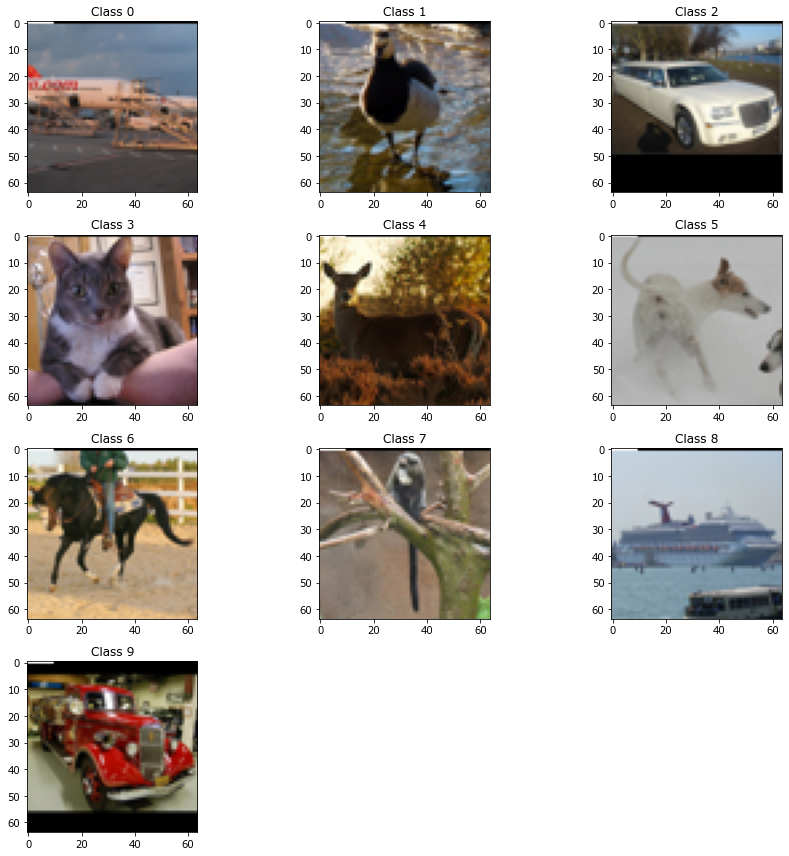

In [16]:
# visualize images from the test dataset
plot_examples_from_dataset(test_images, test_labels)

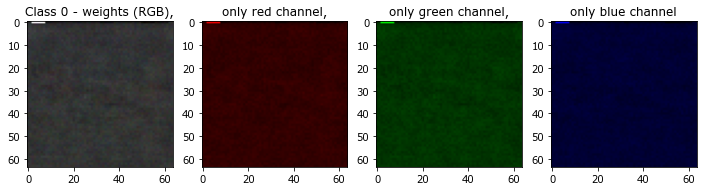

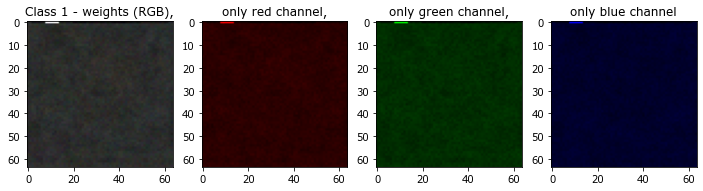

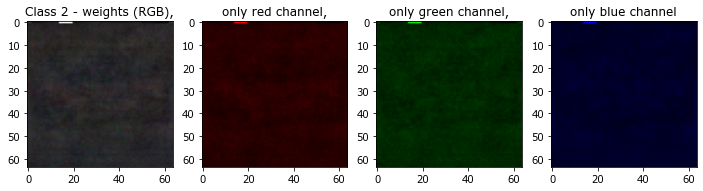

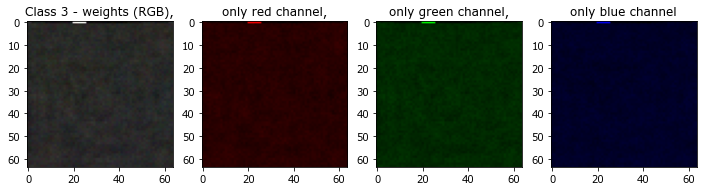

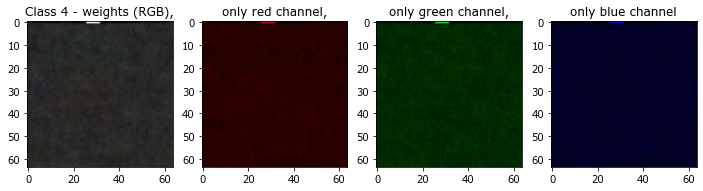

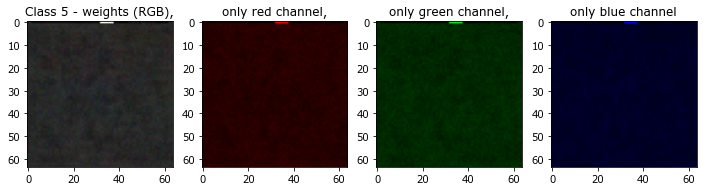

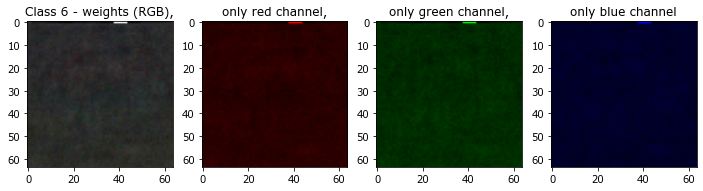

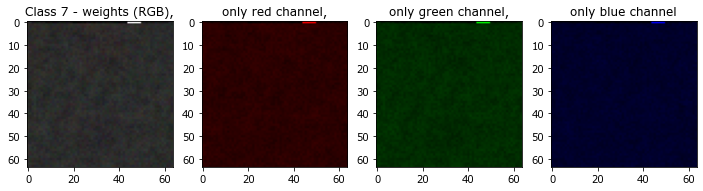

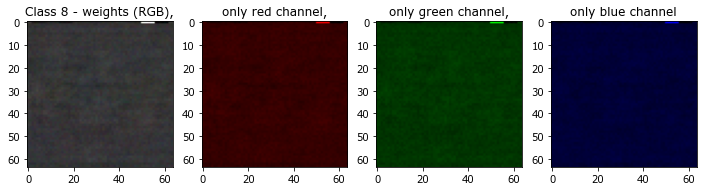

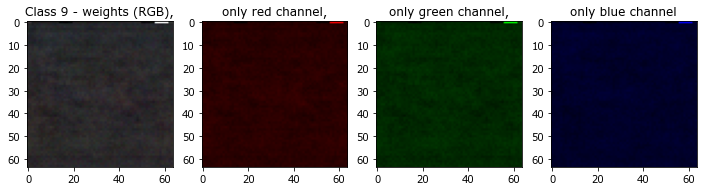

In [17]:
# visualize model's weights
def visualize_model_weights(model_linear, input_shape, output_dim):
    for i in range(output_dim):
        # retrieve weights
        class_weight = model_linear.weight[i].view(input_shape).detach().cpu().numpy()
        class_weight -= class_weight.min()
        class_weight /= class_weight.max()
        
        # plot 4 images per class: "raw" weights, reds only, greens only and blues only
        figure, plots = plt.subplots(ncols=4, figsize=(12,12))
        plots[0].imshow(class_weight)
        plots[0].title.set_text(f'Class {i} - weights (RGB),')
        for color_index, subplot in enumerate(plots[1:]): # R,G,B images
            single_color_weights = np.zeros(class_weight.shape)
            single_color_weights[:,:,color_index] = class_weight[:,:,color_index]
            subplot.imshow(single_color_weights)
            subplot.title.set_text({0:'only red channel,', 1:'only green channel,', 2:'only blue channel'}[color_index])
        
visualize_model_weights(model.linear, input_shape, output_dim)

### Report below:

#### Validation & test accuracy

- Validation average loss: 0.0002, accuracy: 100.0
- Test average loss: 8.0463, accuracy: 10.012

The accuracy is at 100% for the validation but only around 10% when testing with test images. The only explanation for such a gap between the two is a major difference in the train and test datasets. And indeed, when observing the weights of the model - what it learned - we can see a white line of pixels in the first row of each image. Each class has this line at a unique position on its images and the model used it to obtain 100% accuracy on the training set. 

The problem is that in the test set, those lines are all at the same position and therefore cannot be used to distinguish images of different class. The model obtains ~10% accuracy because it predicts class 0 for all images (due to the white pixel line's position).

As no image has pertinent information on its first row of pixels I chose to remove it.

## Task 4. Fix the observed problem

In [25]:
# initialize datasets & dataloaders
normalization = Normalize(mean=(0.5,), std=(0.5,))
remove_first_row = True # this is the flag which implies the removal of the first pixels' row of each image (done in CustomTensorDataset)

train_dataset = CustomTensorDataset(train_images, train_labels, normalization, remove_first_row)
validation_dataset = CustomTensorDataset(val_images, val_labels, normalization, remove_first_row)
test_dataset = CustomTensorDataset(test_images, test_labels, normalization, remove_first_row)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# initialize learning parameters
n_epochs = 100
learning_rate = 0.005 # 0.1, 0.05, 0.01, 0.005, 0.001
input_shape = train_dataloader.dataset.images[0].shape
input_dim = np.prod(input_shape)

# initialize model
model_fixed = LinearModel(input_dim, output_dim)
model_fixed = model_fixed.to(device)

# initialize optimizer and loss function
optimizer = torch.optim.SGD(model_fixed.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# train model
train_losses, train_accuracies, val_losses, val_accuracies = train(model_fixed, 
                                                                   train_dataloader, val_dataloader, 
                                                                   optimizer, loss_fn, 
                                                                   n_epochs)

Epoch 1
Training iteration 0: loss 2.3178
Training iteration 16: loss 1.9446
Training iteration 32: loss 1.9249
Training iteration 48: loss 1.8483
Training iteration 64: loss 1.9120
Train average loss: 1.9536, accuracy: 30.222
Validation average loss: 1.8935, accuracy: 29.0
Epoch 2
Training iteration 0: loss 1.7401
Training iteration 16: loss 2.0575
Training iteration 32: loss 1.7879
Training iteration 48: loss 1.8678
Training iteration 64: loss 1.8127
Train average loss: 1.7963, accuracy: 36.644
Validation average loss: 1.8275, accuracy: 32.2
Epoch 3
Training iteration 0: loss 1.7537
Training iteration 16: loss 1.7148
Training iteration 32: loss 1.8457
Training iteration 48: loss 1.7729
Training iteration 64: loss 1.7367
Train average loss: 1.7165, accuracy: 40.133
Validation average loss: 1.8514, accuracy: 31.6
Epoch 4
Training iteration 0: loss 1.6475
Training iteration 16: loss 1.5116
Training iteration 32: loss 1.5922
Training iteration 48: loss 1.5895
Training iteration 64: loss 

Validation average loss: 1.9097, accuracy: 34.0
Epoch 31
Training iteration 0: loss 0.9819
Training iteration 16: loss 1.3504
Training iteration 32: loss 1.2228
Training iteration 48: loss 1.0957
Training iteration 64: loss 1.0496
Train average loss: 1.1337, accuracy: 66.089
Validation average loss: 1.8883, accuracy: 36.2
Epoch 32
Training iteration 0: loss 1.2062
Training iteration 16: loss 1.0352
Training iteration 32: loss 1.2472
Training iteration 48: loss 1.0856
Training iteration 64: loss 0.9694
Train average loss: 1.1169, accuracy: 66.2
Validation average loss: 1.884, accuracy: 37.0
Epoch 33
Training iteration 0: loss 0.9204
Training iteration 16: loss 1.0934
Training iteration 32: loss 1.1135
Training iteration 48: loss 1.1521
Training iteration 64: loss 1.1295
Train average loss: 1.11, accuracy: 66.0
Validation average loss: 1.8967, accuracy: 36.2
Epoch 34
Training iteration 0: loss 1.0228
Training iteration 16: loss 0.9183
Training iteration 32: loss 1.0666
Training iteration

Validation average loss: 2.029, accuracy: 34.0
Epoch 61
Training iteration 0: loss 0.8846
Training iteration 16: loss 0.7987
Training iteration 32: loss 0.8331
Training iteration 48: loss 1.1761
Training iteration 64: loss 0.8259
Train average loss: 0.8815, accuracy: 76.978
Validation average loss: 2.0123, accuracy: 34.2
Epoch 62
Training iteration 0: loss 0.9759
Training iteration 16: loss 0.7994
Training iteration 32: loss 0.9429
Training iteration 48: loss 0.8302
Training iteration 64: loss 0.7356
Train average loss: 0.87, accuracy: 77.667
Validation average loss: 1.9917, accuracy: 34.6
Epoch 63
Training iteration 0: loss 0.9991
Training iteration 16: loss 0.9083
Training iteration 32: loss 1.0047
Training iteration 48: loss 0.7498
Training iteration 64: loss 0.7659
Train average loss: 0.8645, accuracy: 77.778
Validation average loss: 2.0596, accuracy: 32.8
Epoch 64
Training iteration 0: loss 0.8836
Training iteration 16: loss 0.9322
Training iteration 32: loss 0.8416
Training itera

Validation average loss: 2.1583, accuracy: 33.2
Epoch 91
Training iteration 0: loss 0.6729
Training iteration 16: loss 0.7543
Training iteration 32: loss 0.6318
Training iteration 48: loss 0.7181
Training iteration 64: loss 0.8678
Train average loss: 0.7196, accuracy: 84.378
Validation average loss: 2.1112, accuracy: 34.2
Epoch 92
Training iteration 0: loss 0.7844
Training iteration 16: loss 0.4847
Training iteration 32: loss 0.6015
Training iteration 48: loss 0.8579
Training iteration 64: loss 0.7834
Train average loss: 0.7153, accuracy: 83.8
Validation average loss: 2.1022, accuracy: 33.8
Epoch 93
Training iteration 0: loss 0.6327
Training iteration 16: loss 0.6868
Training iteration 32: loss 0.5500
Training iteration 48: loss 0.7486
Training iteration 64: loss 0.6872
Train average loss: 0.7103, accuracy: 83.711
Validation average loss: 2.126, accuracy: 32.4
Epoch 94
Training iteration 0: loss 0.6944
Training iteration 16: loss 0.6332
Training iteration 32: loss 0.6622
Training itera

In [26]:
print(f'Average loss & accuracy after last training epoch (n° {n_epochs}):')
print(f'Train average loss: {round(train_losses[-1],4)}, accuracy: {round(train_accuracies[-1],4)}')
print(f'Validation average loss: {round(val_losses[-1],4)}, accuracy: {round(val_accuracies[-1],4)}')

Average loss & accuracy after last training epoch (n° 100):
Train average loss: 0.6834, accuracy: 85.5778
Validation average loss: 2.1364, accuracy: 33.8


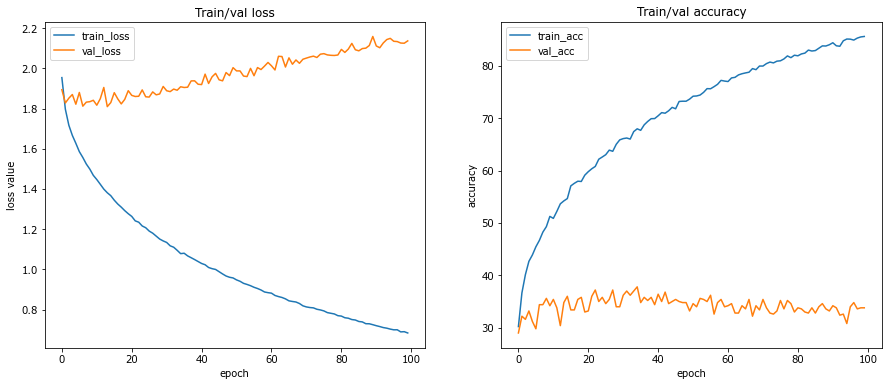

In [27]:
# plot training curves
plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

In [28]:
# test model
_ = evaluate(model_fixed, test_dataloader, loss_fn, False)

Test average loss: 2.1161, accuracy: 33.413


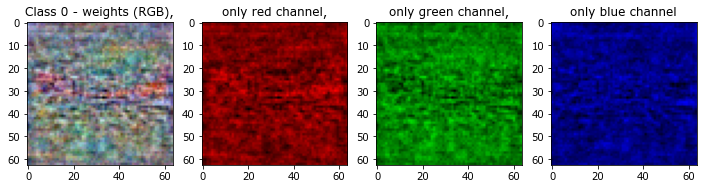

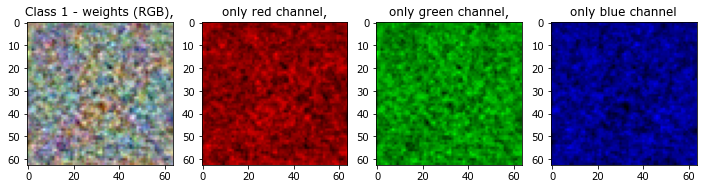

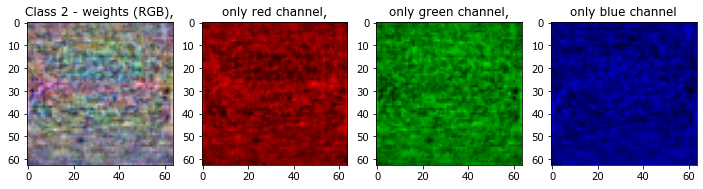

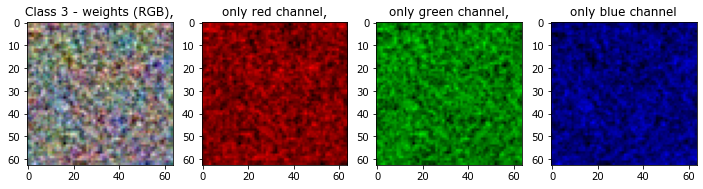

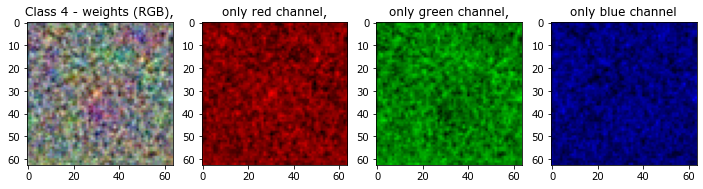

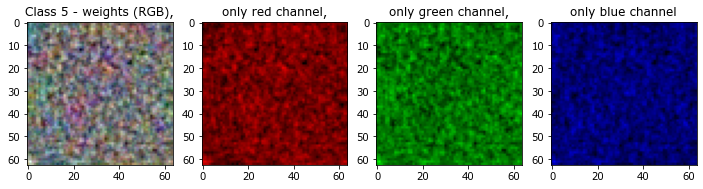

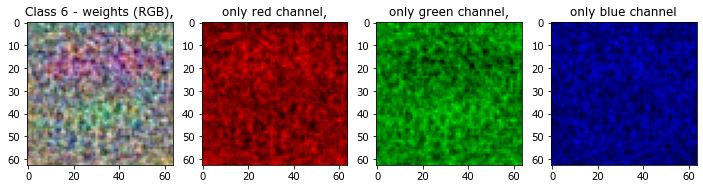

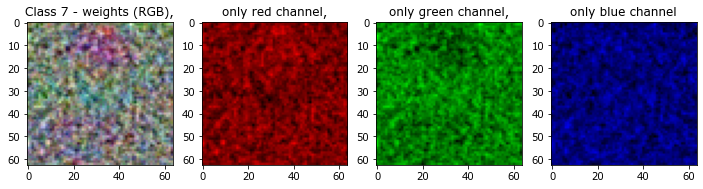

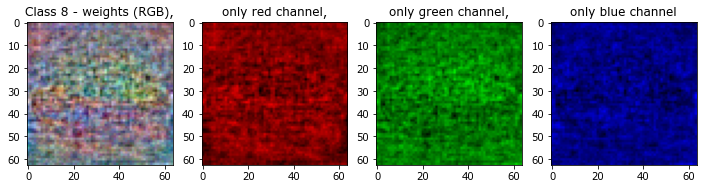

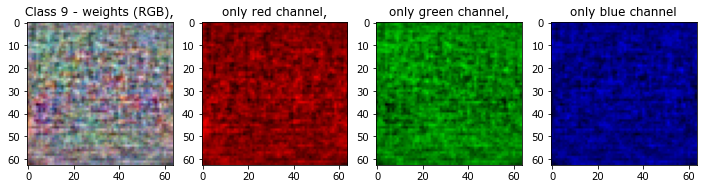

In [29]:
# visualize learning weights
visualize_model_weights(model_fixed.linear, input_shape, output_dim)

#### Report below

##### Models comparison
<table align='left'>
    <tr>
        <th>Learning rate</th>
        <th>Average loss & accuracy</th>
        <th>After epoch 100</th>
    </tr>
    <tr>
        <td><b>0.001</b></td>
        <td><img src='task3_plots/lr_0-001.png' width='600'/></td>
        <td>Train average loss: 1.221, accuracy: 62.6222<br/>Validation average loss: 1.8742, accuracy: 32.6</td>
    </tr>
    <tr>
        <td><b>0.005</b></td>
        <td><img src='task3_plots/lr_0-005.png' width='600'/></td>
        <td>Train average loss: 0.6834, accuracy: 85.5778<br/>Validation average loss: 2.1364, accuracy: 33.8</td>
    </tr>
    <tr>
        <td><b>0.01</b></td>
        <td><img src='task3_plots/lr_0-01.png' width='600'/></td>
        <td>Train average loss: 0.4405, accuracy: 93.7333<br/>Validation average loss: 2.4026, accuracy: 31.4</td>
    </tr>
    <tr>
        <td><b>0.05</b></td>
        <td><img src='task3_plots/lr_0-05.png' width='600'/></td>
        <td>Train average loss: 0.0746, accuracy: 99.8444<br/>Validation average loss: 3.7954, accuracy: 30.6</td>
    </tr>
    <tr>
        <td><b>0.1</b></td>
        <td><img src='task3_plots/lr_0-1.png' width='600'/></td>
        <td>Train average loss: 0.0226, accuracy: 99.7111<br/>Validation average loss: 5.9273, accuracy: 29.8</td>
    </tr>
</table>

##### Selected best performing model

<u>Learning rate: 0.005</u>

<table>
    <tr>
        <th>Previous model (w/ lr=0.1)</th>
        <th>Current/fixed model (w/ lr=0.005)</th></tr>
    <tr>
        <td>Train average loss: 0.0001, accuracy: 100.0<br/>Validation average loss: 0.0002, accuracy: 100.0<br/>Test average loss: 66.2991, accuracy: 14.287</td>
        <td>Train average loss: 0.6834, accuracy: 85.5778<br/>Validation average loss: 2.1364, accuracy: 33.8<br/>Test average loss: 2.1161, accuracy: 33.413</td>
    </tr>
</table>

We can clearly see that the new model is not able to simply learn a basic/recurrent feature (like the previous white pixels lines) to obtain good predictions. Here, the loss is higher and the accuracy is lower than before (on all datasets). This indicates more imprecisions in the model's outputs. The accuracy on the training set is still high as the model learns more and more features each epoch on the input images. Those features are not all pertinent as the accuracy on the validation and test sets doesn't keep growing after a few epochs. By looking at the validation loss we could decide to stop the training after ~20 epochs to avoid overfitting.

<table>
    <tr>
        <th colspan="2" style="text-align:center;">Weights for class 0 (planes) of the old and new model</th>
    </tr>
    <tr>
        <td><img src='task3_plots/weights_omodel.png' width='600' /></td>
        <td><img src='task3_plots/weights_nmodel.png' width='600' /></td>
    </tr>
</table>

The comparison between the weights shows clearly the new model learning different features as the old one only learned the first row of pixels. We can also distinguish straight lines and ellipses in the center of the new model's weight images that were identified as defining features of planes.